## Programming workflow for ECO ADCP DATA - TRURO
### © In_coast lab author: C. Hart, 2024-01-05

In [1]:
# Import necessary libraries
import easygui
import pandas as pd
import glob
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
sys.path.append(r'c:\users\s1495478\appdata\local\packages\pythonsoftwarefoundation.python.3.11_qbz5n2kfra8p0\localcache\local-packages\python311\site-packages')
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

In [2]:
# Parameters
Devicedepth = 1.08
upperlayerdepth = 0.6
middlelayerdepth = 0.76
lowerlayerdepth = 0.92

upperlayer = Devicedepth - lowerlayerdepth
middlelayer = lowerlayerdepth - middlelayerdepth
lowerlayer = middlelayerdepth - upperlayerdepth

print(upperlayer, middlelayer, lowerlayer)

depths = Devicedepth - (upperlayerdepth - lowerlayer*0), Devicedepth - (middlelayerdepth - middlelayer*0), Devicedepth - (lowerlayerdepth - upperlayer*0)

print(depths)

0.16000000000000003 0.16000000000000003 0.16000000000000003
(0.4800000000000001, 0.32000000000000006, 0.16000000000000003)


In [3]:
# read and format ADCP DATA
file_path = r"C:\Users\S1495478\Documents\ADCP\TRURO_2023\TRU_ECO\Nov13-25_format.csv"
df = pd.read_csv(file_path, delimiter=',')
print(df.columns)
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.set_index('DateTime')

Index(['DateTime', 'Upper speed', 'Upper direction', 'Middle speed',
       'Middle direction', 'Lower speed', 'Lower direction', 'Temperature',
       'Depth', 'Tilt'],
      dtype='object')


C:\Users\S1495478\AppData\Local\Temp\ipykernel_15024\1669501289.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DateTime'] = pd.to_datetime(df['DateTime'])


C:\Users\S1495478\AppData\Local\Temp\ipykernel_15024\3356887620.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pf['DateTime'] = pd.to_datetime(pf['Date'] + ' ' + pf['Time'])


Index(['Date', 'Time', 'Pressure'], dtype='object')


<Axes: xlabel='DateTime'>

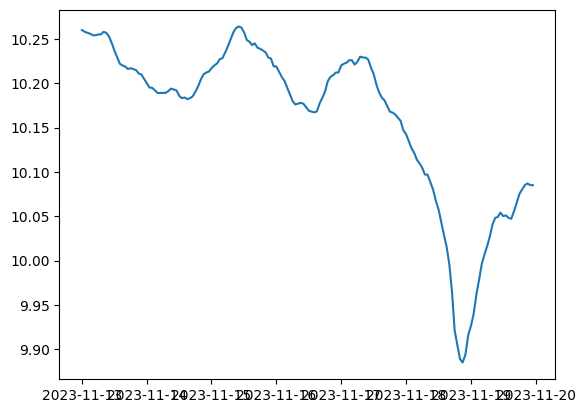

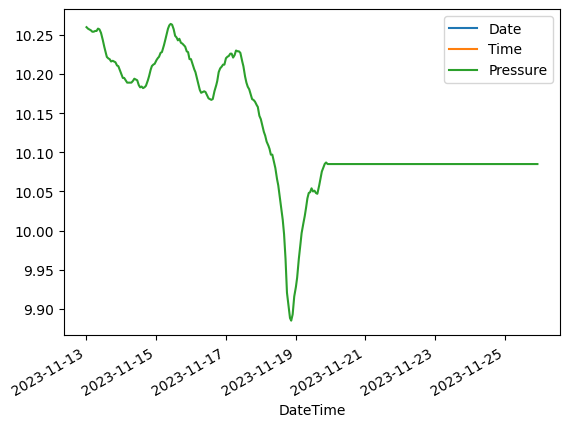

In [4]:
# read pressure data
csv_file_path = r'C:\Users\S1495478\Documents\Weather Underground\ONS_pres_20231113.txt'
pf = pd.read_csv(csv_file_path, delimiter='\t')
pf['DateTime'] = pd.to_datetime(pf['Date'] + ' ' + pf['Time'])
pf = pf.set_index('DateTime')
pf = pf.rename(columns={'pres (kPa)': 'Pressure'})
pf['Pressure'] = pf['Pressure'] / 10
pf = pf.resample('S').interpolate()
print(pf.columns)

# Interpolate pressure timeseries to fit the rsk
interpolated_pf = pf.reindex(df.index)
interpolated_pf['Pressure'] = interpolated_pf['Pressure'].interpolate(method='linear')

plt.plot(pf.index, pf['Pressure'])
interpolated_pf.plot()

In [5]:
DIR = 'Upper direction', 'Middle direction', 'Lower direction'
SPEED = 'Upper speed', 'Middle speed', 'Lower speed'

for i in range(0, 3):
    dir_column = pd.DataFrame({
        'dir_column': df[DIR[i]],  # Example: Sum of existing columns
    })
    df = pd.concat([df, dir_column], axis=1)
    
for i in range(0, 3):
    speed_column = pd.DataFrame({
        'speed_column': df[SPEED[i]],  # Example: Sum of existing columns
    })
    df = pd.concat([df, speed_column], axis=1)

3 4386
3 4386


C:\Users\S1495478\AppData\Local\Temp\ipykernel_15024\86270811.py:16: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  nan_mask = speed_column == 'Nan'
C:\Users\S1495478\AppData\Local\Temp\ipykernel_15024\86270811.py:36: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X, Y, s=310, c=masked_array[:][0:len(df.index)], edgecolor='none', marker='|')


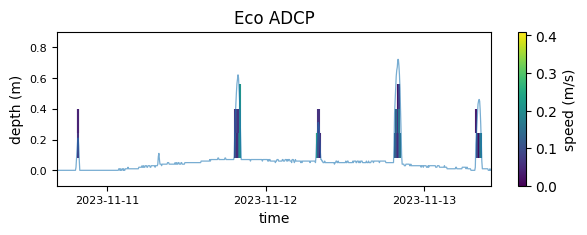

In [29]:
# df = df.resample('T').interpolate()
df['speed_column'] = df['speed_column'].fillna(float(-10))
df['dir_column'] = df['dir_column'].fillna(float(-10))
df['speed_column'] = df['speed_column'].astype(float)
df['dir_column'] = df['dir_column'].astype(float)

dir_column = df['dir_column'].to_numpy()
speed_column = df['speed_column'].to_numpy()

speed_column = np.transpose(speed_column)
dir_column = np.transpose(dir_column)

print(len(speed_column), len(speed_column[0]))
print(len(dir_column), len(dir_column[0]))

nan_mask = speed_column == 'Nan'
speed_column[nan_mask] = (float(-10)) 
dir_column[nan_mask] = (float(-10))

threshold = -9
mask = np.array(speed_column) < threshold
# masked_array = np.ma.masked_less(speed_column, threshold)
masked_array = np.ma.masked_less(speed_column, threshold)

fig, ax1 = plt.subplots(figsize=(7, 2))

# Print the resulting array
# Assuming x and y axes correspond to indices
x_axis = df.index
y_axis = depths

# Create a meshgrid from x and y axes
X, Y = np.meshgrid(x_axis, y_axis)

# Plot the filled contours
plt.scatter(X, Y, s=310, c=masked_array[:][0:len(df.index)], edgecolor='none', marker='|')

# ax2 = ax1.twinx()
plt.plot(df['Depth'], label='water level', linewidth=0.9, alpha=0.6)

num_ticks = 16

date_num = mdates.date2num(x_axis) # Convert datetime objects to numerical values
tick_positions = np.linspace(date_num.min(), date_num.max(), num=num_ticks) # Compute the tick positions
tick_dates = mdates.num2date(tick_positions) # Convert numerical values back to datetime objects

ax1.set_xticks(ticks=tick_dates)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.tick_params(axis='both', which='major', labelsize=8)

# Add color bar for reference
# plt.colorbar(label = 'direction \u00B0')
plt.colorbar(label = 'speed (m/s)')

# Label the axes
plt.xlabel('time')
plt.ylabel('depth (m)')
plt.title('Eco ADCP')

# Set x-axis and y-axis limits
plt.xlim(x_axis[200], x_axis[int(1000)])  # Adjust as needed
plt.ylim(-0.1, 0.9)  # Adjust as needed
# plt.ylim(depths[0]+upperlayer*1, 0)  # Adjust as needed

# plt.ylim(depths[0]-lowerlayer*1, depths[2]+upperlayer*1)  # Adjust as needed
# Save the figure with high resolution
plt.savefig(r"C:\Users\S1495478\Documents\ADCP\Truro_nov23\TRURO_2023_ecoADCP_speed.png", dpi=300)  # Save the plot as a PNG file with 300 DPI

# plt.legend()
# Show the plot
plt.show()

3 4386
3 4386


C:\Users\S1495478\AppData\Local\Temp\ipykernel_15024\2410440206.py:16: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  nan_mask = speed_column == 'Nan'
C:\Users\S1495478\AppData\Local\Temp\ipykernel_15024\2410440206.py:36: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X, Y, s=310, c=masked_array[:][0:len(df.index)], edgecolor='none', marker='|')


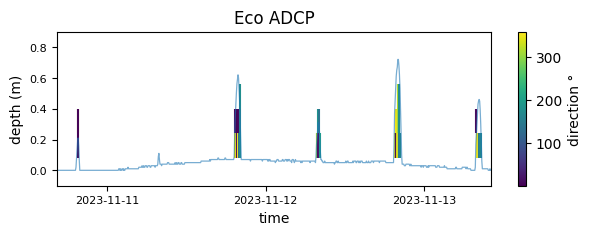

In [30]:
# df = df.resample('T').interpolate()
df['speed_column'] = df['speed_column'].fillna(float(-10))
df['dir_column'] = df['dir_column'].fillna(float(-10))
df['speed_column'] = df['speed_column'].astype(float)
df['dir_column'] = df['dir_column'].astype(float)

dir_column = df['dir_column'].to_numpy()
speed_column = df['speed_column'].to_numpy()

speed_column = np.transpose(speed_column)
dir_column = np.transpose(dir_column)

print(len(speed_column), len(speed_column[0]))
print(len(dir_column), len(dir_column[0]))

nan_mask = speed_column == 'Nan'
speed_column[nan_mask] = (float(-10)) 
dir_column[nan_mask] = (float(-10))

threshold = -9
mask = np.array(speed_column) < threshold
# masked_array = np.ma.masked_less(speed_column, threshold)
masked_array = np.ma.masked_less(dir_column, threshold)

fig, ax1 = plt.subplots(figsize=(7, 2))

# Print the resulting array
# Assuming x and y axes correspond to indices
x_axis = df.index
y_axis = depths

# Create a meshgrid from x and y axes
X, Y = np.meshgrid(x_axis, y_axis)

# Plot the filled contours
plt.scatter(X, Y, s=310, c=masked_array[:][0:len(df.index)], edgecolor='none', marker='|')

# ax2 = ax1.twinx()
plt.plot(df['Depth'], label='water level', linewidth=0.9, alpha=0.6)

num_ticks = 16

date_num = mdates.date2num(x_axis) # Convert datetime objects to numerical values
tick_positions = np.linspace(date_num.min(), date_num.max(), num=num_ticks) # Compute the tick positions
tick_dates = mdates.num2date(tick_positions) # Convert numerical values back to datetime objects

ax1.set_xticks(ticks=tick_dates)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.tick_params(axis='both', which='major', labelsize=8)

# Add color bar for reference
plt.colorbar(label = 'direction \u00B0')
# plt.colorbar(label = 'speed (m/s)')

# Label the axes
plt.xlabel('time')
plt.ylabel('depth (m)')
plt.title('Eco ADCP')

# Set x-axis and y-axis limits
plt.xlim(x_axis[200], x_axis[int(1000)])  # Adjust as needed
plt.ylim(-0.1, 0.9)  # Adjust as needed
# plt.ylim(depths[0]+upperlayer*1, 0)  # Adjust as needed

# plt.ylim(depths[0]-lowerlayer*1, depths[2]+upperlayer*1)  # Adjust as needed
# Save the figure with high resolution
plt.savefig(r"C:\Users\S1495478\Documents\ADCP\Truro_nov23\TRURO_2023_ecoADCP_dir.png", dpi=300)  # Save the plot as a PNG file with 300 DPI

# plt.legend()
# Show the plot
plt.show()